# Pilot Data Analysis
Author: Derya Yavuz


We will analyze our preliminary experiment data we have received from our pilot runs with volunteers at the Gold Lab. 

# List of Questions 

## 1 - Does model complexity differ in report vs. prediction tasks?
Model complexity corresponds to individual differences in making decisions in a changing environment with different hazard rates.

## 2 - Does hazard rate have an effect on performance as a function of the number of trials since last switch?
For each trial, we look at the previous source and compare it with the current source to see if there had been a switch or not. 

## 3 - Does the width of the meta-prior change between prediction and report tasks?

## 4 - How will reaction times be affected by the change point trials in the report task?

## 5 - How will reaction times be affected by trials that are against the hazard rate condition in the prediction task?
For example: switch trials in the low hazard rate condition, and non-switch trials in the high hazard rate condition.

## Plots for Questions

## Question 1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os, sys
import numpy as np
sys.path.append('./Empirical_Information_Bottleneck/predinfo')
from predinfo import predinfo as pi

In [2]:
data_map = os.path.expanduser(
        '~/Documents/GitHub/Analysis_Audio2AFC_ChangePoint/data_mapping.csv'
    )

read_data_map = pd.read_csv(data_map)
read_data_map.head()

,timestamp,subject,block
0,2019_06_25_11_11,1,pred
1,2019_06_25_11_40,1,rep
2,2019_06_25_12_09,2,pred
3,2019_06_25_12_31,2,rep
4,2019_06_27_13_44,3,pred


In [3]:
# First graph : mutual information on the set of trials that is used on every subject.


# Add the hazard rate column. 
# Load the sim_data.csv file.
simulation = os.path.expanduser(
        '~/Documents/GitHub/Analysis_Audio2AFC_ChangePoint/sim_data.csv'
    )

simulation_data = pd.read_csv(simulation)

#Graph 1 calculations
#Vectors
 
tones = simulation_data['sound'].copy()
hazards = simulation_data['hazard'].copy()

#For the report task.
tones[tones == 'left'] = 0
tones[tones == 'right'] = 1
#Mutual information in bits.
tone_ipast,tone_ifuture = pi(tones,tones,1,1,2,2)
print(tone_ipast)

#For predict task.
features = np.empty(len(tones))
features[(tones == 0) & (hazards == .1)] = 0
features[(tones == 1) & (hazards == .1)] = 1
features[(tones == 1) & (hazards == .9)] = 3
features[(tones == 0) & (hazards == .9)] = 2

#print(features)

tone_ipast_feature,tone_ifuture_feature = pi(features,features,1,1,4,4)
print(tone_ipast_feature)


0.005203623309333865
0.8977714940385852


In [4]:
#Function to create vectors for the individual mutual information plot per subject in the report task.

def create_vectors_rep(rep_data):
    #Create responses vector, excluding the NaN values.
    responses_rep = rep_data['choice'].copy()
    responses_correct_rep = rep_data['correct'].copy()
    responses_nan_rep = np.isnan(responses_correct_rep)
    responses_rep = responses_rep[responses_nan_rep == False]

    #Create tones vector for the report task, converting all values to either 1 or 0.
    tones_raw_rep = rep_data['direction'].copy()
    tones_raw_rep = tones_raw_rep[responses_nan_rep == False]
    tones_raw_rep[tones_raw_rep == 180] = 1
    
    #Create a hazards vector to incorporate the hazard rate into the features.
    hazards_raw_rep = rep_data['hazard'].copy()
    hazards_raw_rep = hazards_raw_rep[responses_nan_rep == False]
    
    return tones_raw_rep, hazards_raw_rep, responses_rep

In [5]:
#Function to create vectors for the individual mutual information plot per subject in the prediction task.

def create_vectors_pred(pred_data):
    responses_pred = pred_data['choice'].copy()
    responses_correct_pred = pred_data['correct'].copy()
    responses_nan_pred = np.isnan(responses_correct_pred)
    responses_pred = responses_pred[responses_nan_pred == False]

    #Create tones vector for the prediction task, converting all values to either 1 or 0.
    tones_raw_pred = pred_data['direction'].copy()
    tones_raw_pred = tones_raw_pred[responses_nan_pred == False]
    tones_raw_pred[tones_raw_pred == 180] = 1

    #Create a hazards vector to incorporate the hazard rate into the features.
    hazards_raw_pred = pred_data['hazard'].copy()
    hazards_raw_pred = hazards_raw_pred[responses_nan_pred == False]
    
    return tones_raw_pred, hazards_raw_pred, responses_pred


In [6]:
def process_rep(rep_data):
    tones_raw_rep, hazards_raw_rep, responses_rep = create_vectors_rep(rep_data)
    features_rep = feature_func(tones_raw_rep, hazards_raw_rep)
    
    
    #Shifting rows to provide an offset for the function.
    responses_rep_shift = responses_rep[1:]
    feature_rep_shift = features_rep[0:(len(features_rep)-1)]

    sub1_ipast_rep, sub1_ifuture_rep = pi(responses_rep_shift, feature_rep_shift, 1, 1, 2, 4)
    return sub1_ipast_rep

In [7]:
def process_pred(pred_data):
    tones_raw_pred, hazards_raw_pred, responses_pred = create_vectors_pred(pred_data)
    features_pred = feature_func(tones_raw_pred, hazards_raw_pred)

    #Shifting rows to provide an offset for the function.
    responses_pred_shift = responses_pred[1:]
    feature_pred_shift = features_pred[0:(len(features_pred)-1)]

    #Apply the mutual information function to the features, print out the mutual information in the report task per subject.
    sub1_ipast_pred, sub1_ifuture_pred = pi(responses_pred_shift, feature_pred_shift, 1, 1, 2, 4)
    return sub1_ipast_pred



In [8]:
def get_timestamp(dataframe, subject, task_type):
    timestamp = dataframe[(dataframe['subject']==subject) & (dataframe['block']==task_type)]
    return timestamp.iloc[0,0]

In [10]:
#Load in the data
#Subject 1 rep and pred. These are raw data files since we need the actual number of trials. Processed ones are missing
#a couple of trials which complicate the analysis.

#Create an array for both rep and pred mutual information numbers to be stored.
ipast_rep = []
ipast_pred = []


num_subjects = 4

for subject in range(num_subjects):
    
    #Loading and reading the .csv files.
    rep = os.path.expanduser(
        '~/Documents/MATLAB/Audio2AFC_CP/raw/' +
        get_timestamp(read_data_map, subject+1, 'rep') + '/pilot' +
        str(subject+1) + 'rep_FIRA.csv'
    )
    
    
    
    #os.path.expanduser('~/Documents/MATLAB/Audio2AFC_CP/raw/2019_06_25_11_40/pilot1rep_FIRA.csv')
    pred = os.path.expanduser(
        '~/Documents/MATLAB/Audio2AFC_CP/raw/' + get_timestamp(read_data_map, subject+1, 'pred') + '/pilot' +
        str(subject+1) + 'pred_FIRA.csv'
    )
    

   
    #os.path.expanduser('~/Documents/MATLAB/Audio2AFC_CP/raw/2019_06_25_11_11/pilot1pred_FIRA.csv')
    rep_data = pd.read_csv(rep)
    pred_data = pd.read_csv(pred)

    #Cleaning up: dropping the unwanted columns for a cleaner dataframe.
    rep_data = rep_data.drop(["trialStart", "trialEnd", "RT", "isCatch", "unselectedTargetOff", "sound1On", "sound2On", 
                               "sound1Off", "sound2Off", "choiceTime", "secondChoiceTime", "targetOff", "fixationOff", "dirReleaseChoiceTime"], axis=1)

    pred_data = pred_data.drop(["trialStart", "trialEnd", "RT", "isCatch", "unselectedTargetOff", "sound1On", "sound2On", 
                               "sound1Off", "sound2Off", "choiceTime", "secondChoiceTime", "targetOff", "fixationOff", "dirReleaseChoiceTime"], axis=1)

    #Append hazard rate column. 
    rep_data = rep_data.merge(simulation_data['hazard'], left_index=True, right_index=True)
    pred_data = pred_data.merge(simulation_data['hazard'], left_index=True, right_index=True)
    
    #Process each data frame individually, then append them. 
    subj_past_rep = process_rep(rep_data)
    ipast_rep.append(subj_past_rep)
    subj_past_pred = process_pred(pred_data)
    ipast_pred.append(subj_past_pred)
    
    print(subj_past_rep)
    print(subj_past_pred)



0.034857067716777046
0.0012953077709271653
0.03665941926130263
0.3300807097143858
0.04050922383208016
0.1671460715631315
0.044655549224807654
0.14391808495198244


In [9]:
def feature_func(tones, hazards):
    features = np.empty(len(tones))
    features[(tones == 0) & (hazards == .1)] = 0
    features[(tones == 1) & (hazards == .1)] = 1
    features[(tones == 1) & (hazards == .9)] = 3
    features[(tones == 0) & (hazards == .9)] = 2
    return features

Text(0, 0.5, 'Complexity (bits)')

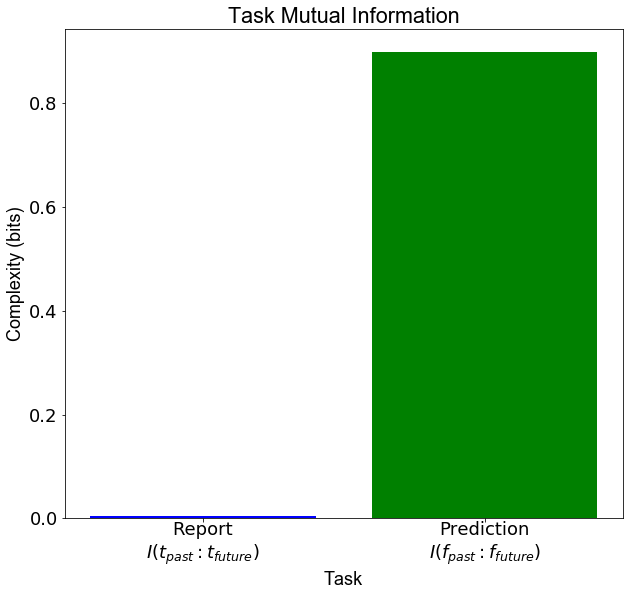

In [11]:
#Plotting the graphs containing mutual information.
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 9) # (w, h) # figure size 
plt.rcParams.update({'font.size': 18})
names = ('Report\n$I(t_{past}:t_{future})$','Prediction\n$I(f_{past}:f_{future})$')
plt.bar([0,1],[tone_ipast,tone_ipast_feature],align='center',color=['b','g'])
plt.xticks([0,1],names)
plt.title("Task Mutual Information", fontname="Arial")
plt.xlabel('Task', fontname="Arial")
plt.ylabel('Complexity (bits)', fontname="Arial")


Text(0, 0.5, 'Complexity (bits)')

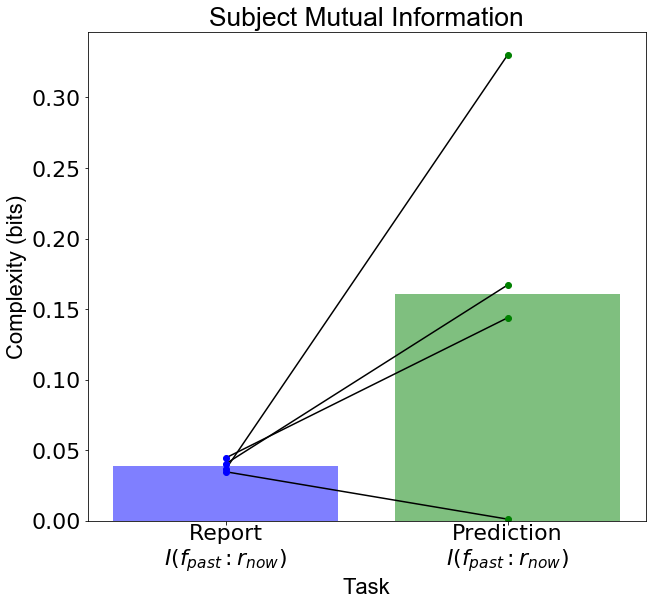

In [12]:
#Plotting the graphs containing mutual information.
#Second graph: per subject.
#vector_bit = np.arange(0,1)

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 9) # (w, h) # figure size 
plt.rcParams.update({'font.size': 22})
names = ('Report\n$I(f_{past}:r_{now})$','Prediction\n$I(f_{past}:r_{now})$')
plt.bar([0,1],[np.mean(ipast_rep), np.mean(ipast_pred)],align='center',color=['b','g'],alpha=.5)

#Draw the lines between the points associating each subject's report and prediction complexity, individually.
for i in np.arange(len(ipast_rep)):
    plt.plot([0,1],[ipast_rep[i],ipast_pred[i]],'k-')
    
plt.plot([0,0,0,0],ipast_rep,color='b',marker='o')
plt.plot([1,1,1,1],ipast_pred,color='g',marker='o',linewidth=0)
plt.xticks([0,1],names)
plt.title("Subject Mutual Information", fontname="Arial")
plt.xlabel('Task', fontname="Arial")
plt.ylabel('Complexity (bits)', fontname="Arial")

## Question 2

This will load the .csv file containing the processed data.

In [ ]:
# # Automate timestamps. 
# # Loading the data mapping timestamps which associates subjects to their respective trials.
# data_map = os.path.expanduser(
#         '~/Documents/GitHub/Analysis_Audio2AFC_ChangePoint/data_mapping.csv'
#     )

# read_data_map = pd.read_csv(data_map)
# read_data_map.head()

In [ ]:
# def produce_df(file_name):
#     data = pd.read_csv(file_name)
#     data = data.drop(["trialStart", "trialEnd", "RT", "direction", "isCatch", "unselectedTargetOff", "sound1On", "sound2On", 
#                            "sound1Off", "sound2Off", "choiceTime", "secondChoiceTime", "targetOff", "fixationOff", "dirReleaseChoiceTime"], axis=1)


#     # Adding a column to indicate source switches.
#     switchCol = [1] * data.count()
#     data['sourceSwitch'] = switchCol

#     # Adding another column to indicate the number of trials that has passed since the last source switch occurred.
#     positionCol = [1] * data.count()
#     data['posSinceCP'] = positionCol
    
#     # Add the hazard rate column. 
#     # Load the sim_data.csv file.
#     simulation = os.path.expanduser(
#             '~/Documents/GitHub/Analysis_Audio2AFC_ChangePoint/sim_data.csv'
#     )
    
#     simulation_data = pd.read_csv(simulation)
#     data = data.merge(simulation_data['hazard'], left_index=True, right_index=True)
    
#     # Iterate over the rows in the source, checking the previous row and comparing it to the first one to see if there is 
#     # a source switch.
#     # This fills out the sourceSwitch column.

#     data['sourceChange'] = data['source'].shift(1)
#     data['sourceSwitch'] = data['source'] != data['sourceChange']
    
#     # Iterate over the rows in the sourceSwitch column and fill the posSinceCP column. 
#     #If there has been a switch, set the counter to 0, else, keep on iterating the counter. 

#     count_switches = 0

#     for row_number in range(len(data)):

#         isSwitch = data.iloc[row_number, 4]
#         if isSwitch:
#             count_switches = 0
#         else:
#             count_switches+=1
#         data.iloc[row_number, 5] = count_switches
    
#     return data


    

In [ ]:
# def extract_hazard(data):
#     # Finding the maximum value in the posSinceCP column to find the range of iterations.

#     high_hazard_extracted = data[data['hazard'] == 0.9].copy()
#     low_hazard_extracted = data[data['hazard'] == 0.1].copy()
#     max_value_high = high_hazard_extracted['posSinceCP'].max()
#     max_value_low = low_hazard_extracted['posSinceCP'].max()
    
    
#     #List to keep track of the percentage correct per value of the position counter.
#     list_of_percentages_low = []
#     list_of_percentages_high = []

#     # Calculates % correct per each value of position counter: number of correct answers / number of trials (rows).
#     # For high hazard rate.
#     for val in range(0, int(max_value_high+1)):

#         extracted_df_high = data[(data['posSinceCP'] == val) & (data['hazard']==0.9)].copy()
#         percent_correct_high = extracted_df_high['correct'].sum() / len(extracted_df_high)
#         list_of_percentages_high.append(percent_correct_high)
        

#     # Calculates % correct per each value of position counter: number of correct answers / number of trials (rows).
#     # For low hazard rate.
#     for val in range(0, int(max_value_low+1)):

#         extracted_df_low = data[(data['posSinceCP'] == val) & (data['hazard']==0.1)].copy()
#         percent_correct_low = extracted_df_low['correct'].sum() / len(extracted_df_low)
#         list_of_percentages_low.append(percent_correct_low)
        
#     vector_high = np.arange(0,(max_value_high+1))
#     vector_low = np.arange(0, (max_value_low+1))
    
        
#     return list_of_percentages_high, list_of_percentages_low, vector_high, vector_low

In [ ]:
# def get_timestamp(dataframe, subject, task_type):
#     timestamp = dataframe[(dataframe['subject']==subject) & (dataframe['block']==task_type)]
#     return timestamp.iloc[0,0]


In [ ]:
# # Specify the full path name to the data folder.
# # This needs to be done per subject and per each session separately.

# pred_list = []
# rep_list = []

# num_subjects = 4
# for subject in range(num_subjects): 
    
#     # Subject 1 Report Task 
#     rep = os.path.expanduser(
#         '~/Documents/MATLAB/Audio2AFC_CP/processed/' +
#         get_timestamp(read_data_map, subject+1, 'rep') + '/pilot' +
#         str(subject+1) + 'rep_FIRA_valid_trials.csv'
#     )
    
#     processed_rep = produce_df(rep)
#     rep_list.append(processed_rep)

#     # Subject 1 Prediction Task 
#     pred = os.path.expanduser(
#         '~/Documents/MATLAB/Audio2AFC_CP/processed/' + get_timestamp(read_data_map, subject+1, 'pred') + '/pilot' +
#         str(subject+1) + 'pred_FIRA_valid_trials.csv'
#     )
    
#     processed_pred = produce_df(pred)
#     pred_list.append(processed_pred)



# final_data_rep = pd.concat(rep_list)
# final_data_pred = pd.concat(pred_list)

# high_rep_list, low_rep_list, vector_rep_high, vector_rep_low = extract_hazard(final_data_rep)
# high_pred_list, low_pred_list, vector_pred_high, vector_pred_low = extract_hazard(final_data_pred)



In [ ]:
# counter =0
# high_h = final_data_pred[final_data_pred['hazard']==0.9].copy()
# for row in range(len(high_h)):
#     counter = counter + 1 if not high_h['sourceSwitch'].iloc[row] else 0
#     if counter == 2:
#         print(row)
#         break

In [ ]:
# print(high_h.iloc[135:145, :])

In [ ]:
# simulation = os.path.expanduser(
#         '~/Documents/GitHub/Analysis_Audio2AFC_ChangePoint/sim_data.csv'
# )

# simulation_data = pd.read_csv(simulation)
# # high_h2 = simulation_data[simulation_data['hazard']==0.9].copy()
# print(simulation_data.iloc[275:285,:])

In [ ]:
# # Plotting: percent correct vs. number of trials since the changepoint. 
# %matplotlib inline
# plt.rcParams["figure.figsize"] = (10, 9) # (w, h) # figure size 
# plt.rcParams.update({'font.size': 18})

# #Plotting the report task over 4 subjects.
# plt.plot(vector_rep_low, low_rep_list, linewidth = 2)
# plt.plot(vector_rep_high, high_rep_list, linewidth = 2)
# plt.title("Report Task")
# plt.legend(['low hazard rate', 'high hazard rate'])
# plt.xlabel('number of trials since change point')
# plt.ylabel('percentage correct')


In [ ]:
# # Plotting the prediction task over 4 subjects.
# plt.plot(vector_pred_low, low_pred_list, linewidth = 2)
# plt.plot(vector_pred_high, high_pred_list, linewidth = 2)
# plt.title("Prediction Task")
# plt.legend(['low hazard rate', 'high hazard rate'])
# plt.xlabel('number of trials since change point')
# plt.ylabel('percentage correct')


In [ ]:
# simulation = os.path.expanduser(
#         '~/Documents/GitHub/Analysis_Audio2AFC_ChangePoint/sim_data.csv'
# )

# simulation_data = pd.read_csv(simulation)
# high_h = simulation_data[simulation_data['hazard']==0.9].copy()
# high_h.head()

In [ ]:
# row = 0
# print(type(high_h['source_switch'].iloc[row]))

In [ ]:
# a=1 if 2==3 else 0
# print(a)

In [ ]:
# counter =0
# for row in range(len(high_h)):
#     counter = counter + 1 if not high_h['source_switch'].iloc[row] else 0
#     if counter == 2:
#         print(row)
#         break